## Array Analysis

In [1]:
# Parameters
experiment_config_path = None
experiment_output_dir = None
na_growth_rate_fill_value = None

In [2]:
# # Debugging
# experiment_config_path = '/lab/repos/celldom/config/experiment/exp-20180614-G3-K562-imatinib-poc-01.yaml'
# # experiment_output_dir = '/lab/data/celldom/output/20180923-G3-full'
# #experiment_output_dir = '/lab/data/celldom/output/20181115-G3-sample-array-tzero'
# experiment_output_dir = '/lab/data/celldom/output/20181005-G3-full'
# na_growth_rate_fill_value = 0

In [3]:
assert experiment_config_path, 'Must provide value for parameter `experiment_config_path`'
assert experiment_output_dir, 'Must provide value for parameter `experiment_output_dir`'

if str(na_growth_rate_fill_value) == 'None':
    na_growth_rate_fill_value = None
else:
    na_growth_rate_fill_value = float(na_growth_rate_fill_value)

In [4]:
%run -m celldom.nb.logging
%matplotlib inline
import celldom
import os
import os.path as osp
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
from skimage import io
from celldom.core.experiment import Experiment
from celldom.config import experiment_config
from celldom.execute import view

In [5]:
config = experiment_config.ExperimentConfig(experiment_config_path)
experiment = Experiment(config, data_dir=experiment_output_dir)
view.build_all(experiment)

In [6]:
def get_apartment_summary_data():
    df = experiment.get_view_store().get('apartment_summary')
    df = view.remove_oob_apartments(experiment, df)
    df['array'] = df[config.experimental_condition_fields].apply(':'.join, axis=1)

    # Apply NA growth rate placeholder, if provided
    if na_growth_rate_fill_value is not None:
        df['growth_rate'] = df['growth_rate'].fillna(na_growth_rate_fill_value)

    # Ignore invalid growth rates (Note that the fill value above provides a way to distinguish
    # between apartments with no data and apartments with conditions ineligible for growth rate calculation)
    df = df[df['growth_rate'].notnull()]
    return df

df = get_apartment_summary_data()

2018-11-16 13:39:51,819:INFO:celldom.execute.view: Removing 43 rows of 15637 from data frame with apartment/street numbers outside of expected range (apartment range = [0, 57], street range = [0, 15])


In [7]:
df['growth_rate'].describe()

count    15594.000000
mean         0.025347
std          0.252507
min         -0.651253
25%         -0.061114
50%          0.000000
75%          0.048055
max          1.499744
Name: growth_rate, dtype: float64

### Growth Rates

These heatmaps show growth rates for individual apartments where any individual growth rate may be missing due to:
- Apartment not ever identified in raw images
- Only a single cell count is present (growth rates for one time point not possible)
- Apartment does not meet the initial conditions criteria (single_cell, double_cell, etc.)

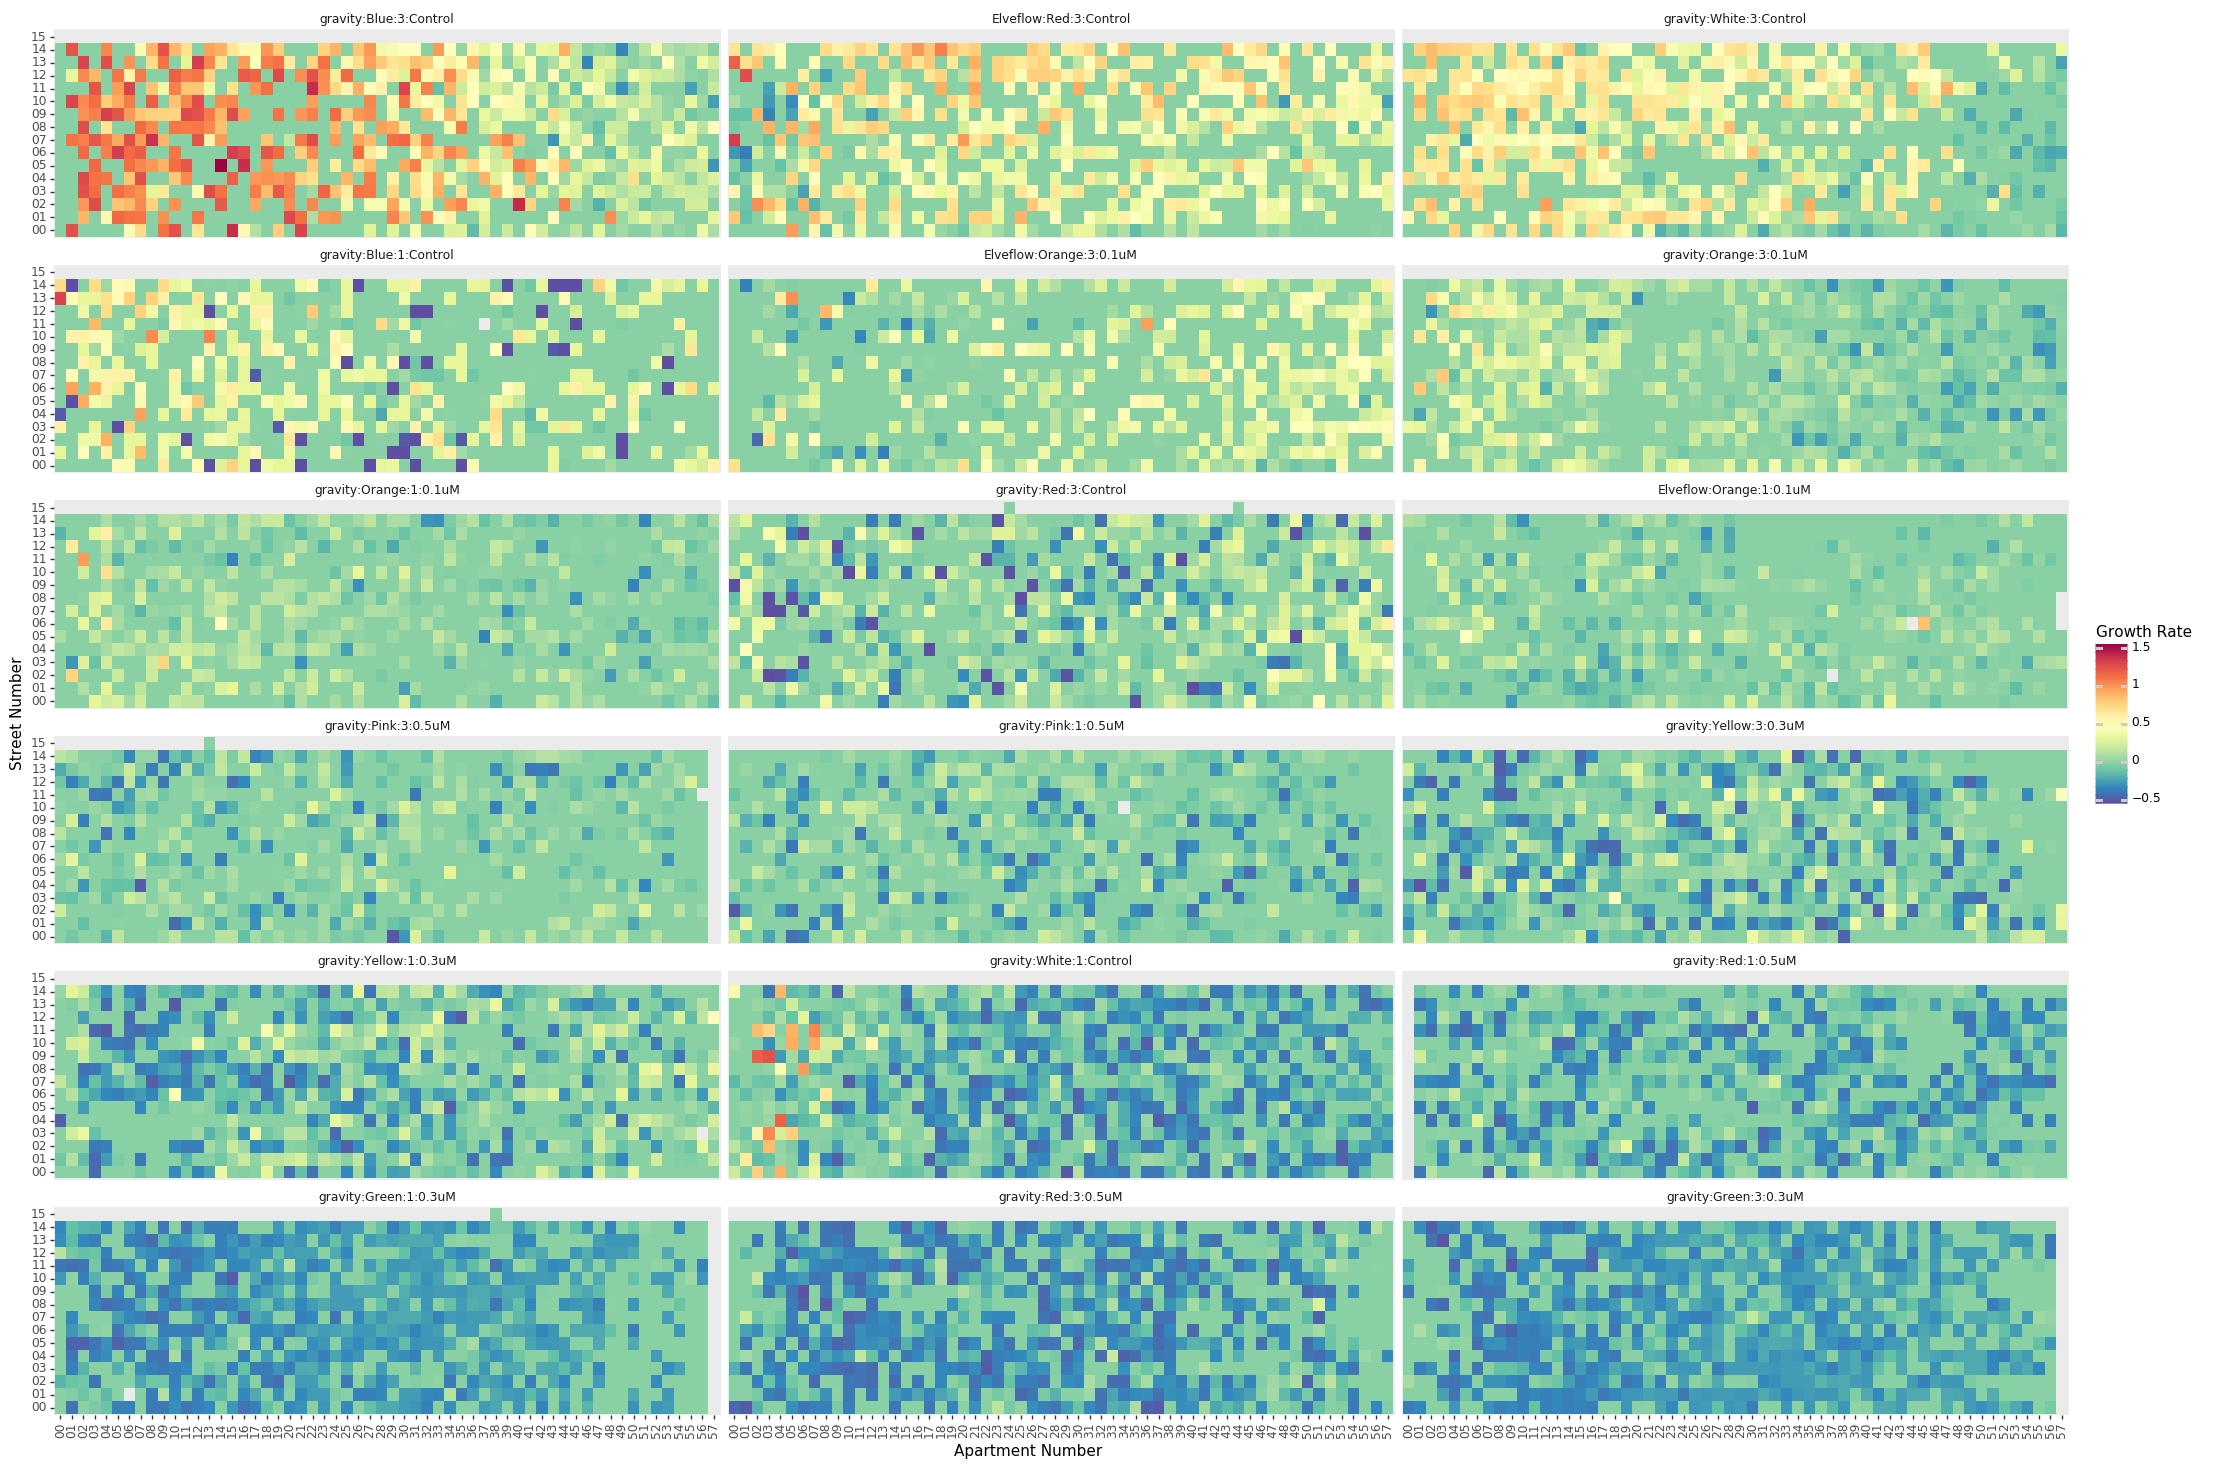

<ggplot: (8784805711017)>

In [8]:
arrct = df['array'].nunique()
(
    pn.ggplot(
        (
            df
            .assign(array=pd.Categorical(
                df['array'], ordered=True,
                categories=df.groupby('array')['growth_rate'].mean().sort_values(ascending=False).index
            ))
            .rename(columns={'growth_rate': 'Growth Rate'})
        ), 
        pn.aes(x='apt_num', y='st_num', fill='Growth Rate')
    ) +
    pn.geom_tile() +
    pn.scale_fill_cmap(name='Spectral_r', limits=(-.5, 1.5)) +
    pn.facet_wrap('~array', ncol=3) +
    pn.xlab('Apartment Number') +
    pn.ylab('Street Number') +
    pn.theme(
        figure_size=(26, 3 * int(np.ceil(arrct / 3))),
        axis_text_x=pn.element_text(rotation=90, hjust=.5),
        panel_grid_major=pn.element_blank(),
        panel_grid_minor=pn.element_blank(),
        strip_background=pn.element_rect(fill="white")
    )
)

### Confluence

This heatmap indicates apartments that ever reached a state of "confluence":

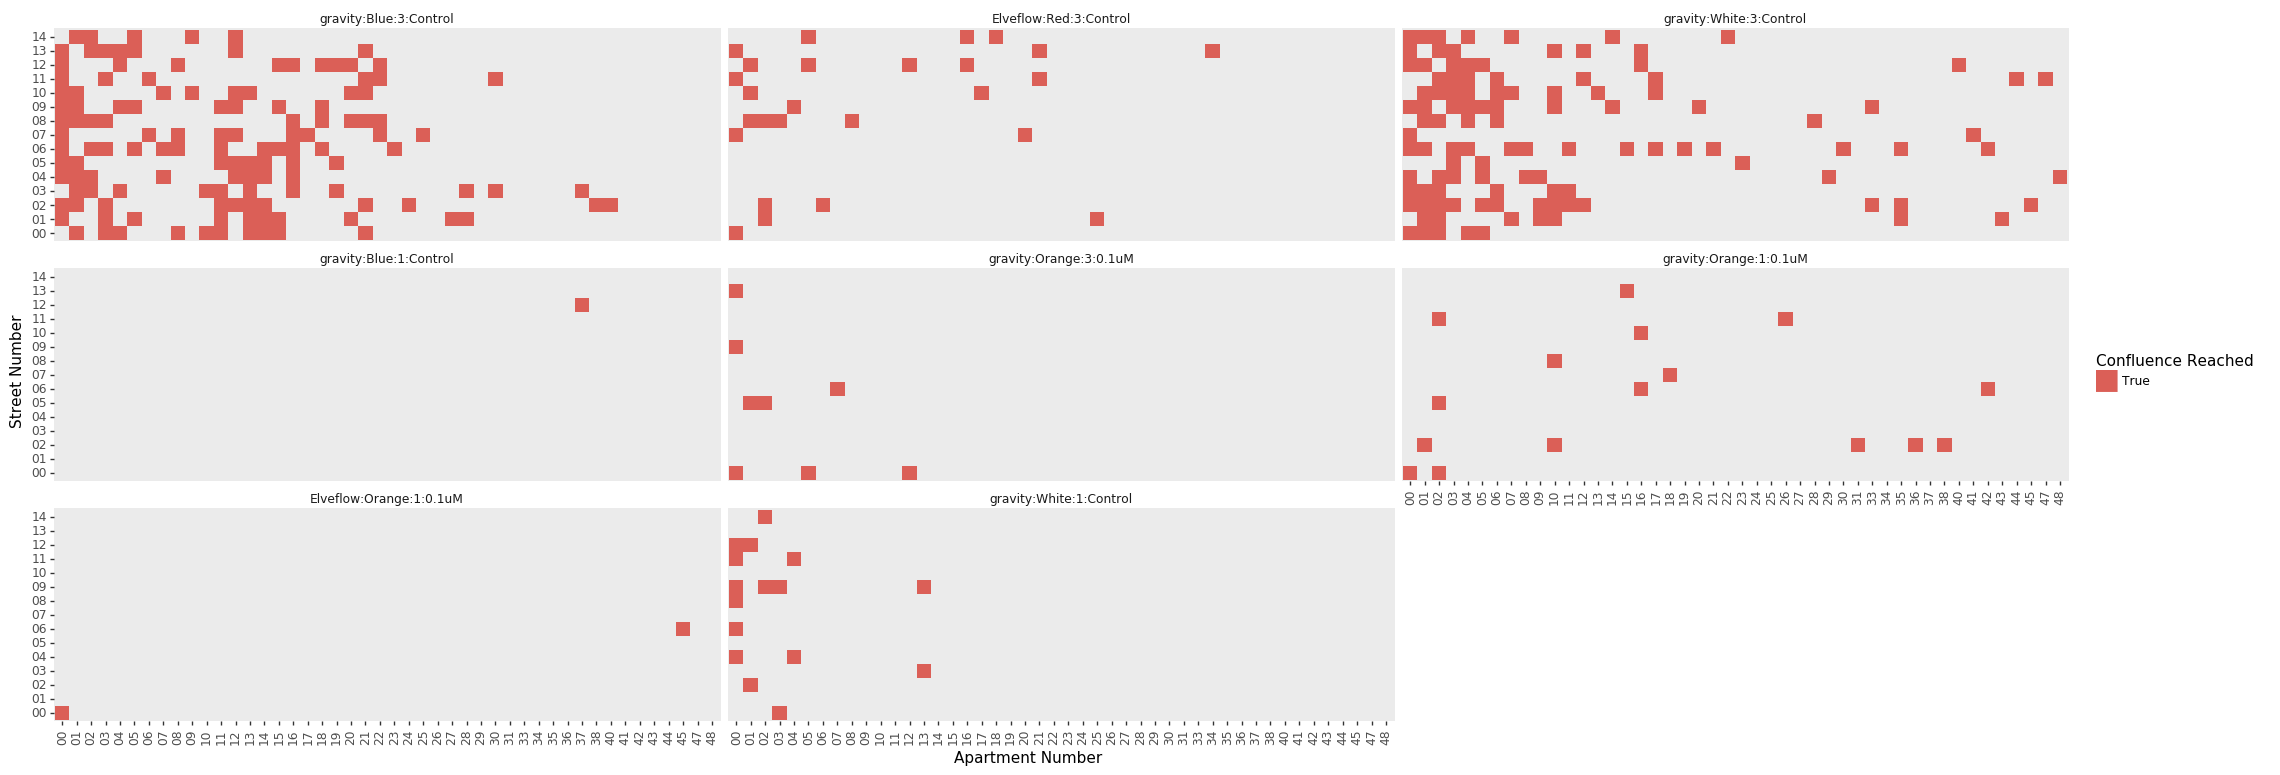

<ggplot: (-9223363252050536693)>

In [9]:
import json
df_conf = (
    df
    .assign(confluence=df['confluence'].apply(lambda v: np.max(list(json.loads(v).values()))))
    .assign(array=pd.Categorical(
        df['array'], ordered=True,
        categories=df.groupby('array')['growth_rate'].mean().sort_values(ascending=False).index
    ))
    .loc[lambda d: d['confluence'] == True]
    .rename(columns={'confluence': 'Confluence Reached'})
)
arrct = df_conf['array'].nunique()
def disp():
    if len(df_conf) > 0:
        return (
            pn.ggplot(
                df_conf, 
                pn.aes(x='apt_num', y='st_num', fill='Confluence Reached')
            ) +
            pn.geom_tile() +
            pn.facet_wrap('~array', ncol=3) +
            pn.xlab('Apartment Number') +
            pn.ylab('Street Number') +
            pn.theme(
                figure_size=(26, 3 * int(np.ceil(arrct / 3))),
                axis_text_x=pn.element_text(rotation=90, hjust=.5),
                panel_grid_major=pn.element_blank(),
                panel_grid_minor=pn.element_blank(),
                strip_background=pn.element_rect(fill="white")
            )
        )
disp()

### Trapping Efficiency

This table shows what percentage of apartments in each array began with a single cell (as well as other cell counts):

In [10]:
def get_pivot_data(df, count_field):
    if count_field not in df:
        return None
    def classify(ct):
        if pd.isnull(ct):
            return 'No t0'
        ct = int(round(ct))
        return str(ct) if ct < 5 else '5+'
    dfc = (
        df
        .assign(initial_cell_count=df[count_field].apply(classify))
        .groupby(config.experimental_condition_fields + ['initial_cell_count']).size().rename('count')
        .unstack()
    )
    dfn = dfc.sum(axis=1)
    dfp = dfc.divide(dfn, axis=0)
    dfo = pd.concat([dfp, dfn.rename('n_apartments')], axis=1)
    dfo.columns.name = 'initial_cell_count'
    return dfo

def disp(df):
    if df is None:
        return 'No data for component available'
    if '1' in df:
        return (
            df.sort_values('1', ascending=False)
            .style.background_gradient(subset='1', cmap='RdYlGn')
            .format('{:.1%}', subset=[c for c in df.columns if c != 'n_apartments'])
        )
    else:
        return dfo

*Chamber Percentages:*

In [11]:
count_field = 'tz_count_any_chamber'
disp(get_pivot_data(df, count_field))

*Trap Percentages:*

In [12]:
count_field = 'tz_count_any_trap'
disp(get_pivot_data(df, count_field))

'No data for component available'

### Cell Counts

This figure shows the total number of cells across the arrays, for each time point:

In [13]:
def get_apartment_data():
    df = experiment.get_view_store().get('apartment')
    df = view.remove_oob_apartments(experiment, df)
    df['array'] = df[config.experimental_condition_fields].apply(':'.join, axis=1)
    return df

df = get_apartment_data()

2018-11-16 13:40:03,747:INFO:celldom.execute.view: Removing 64 rows of 136460 from data frame with apartment/street numbers outside of expected range (apartment range = [0, 57], street range = [0, 15])


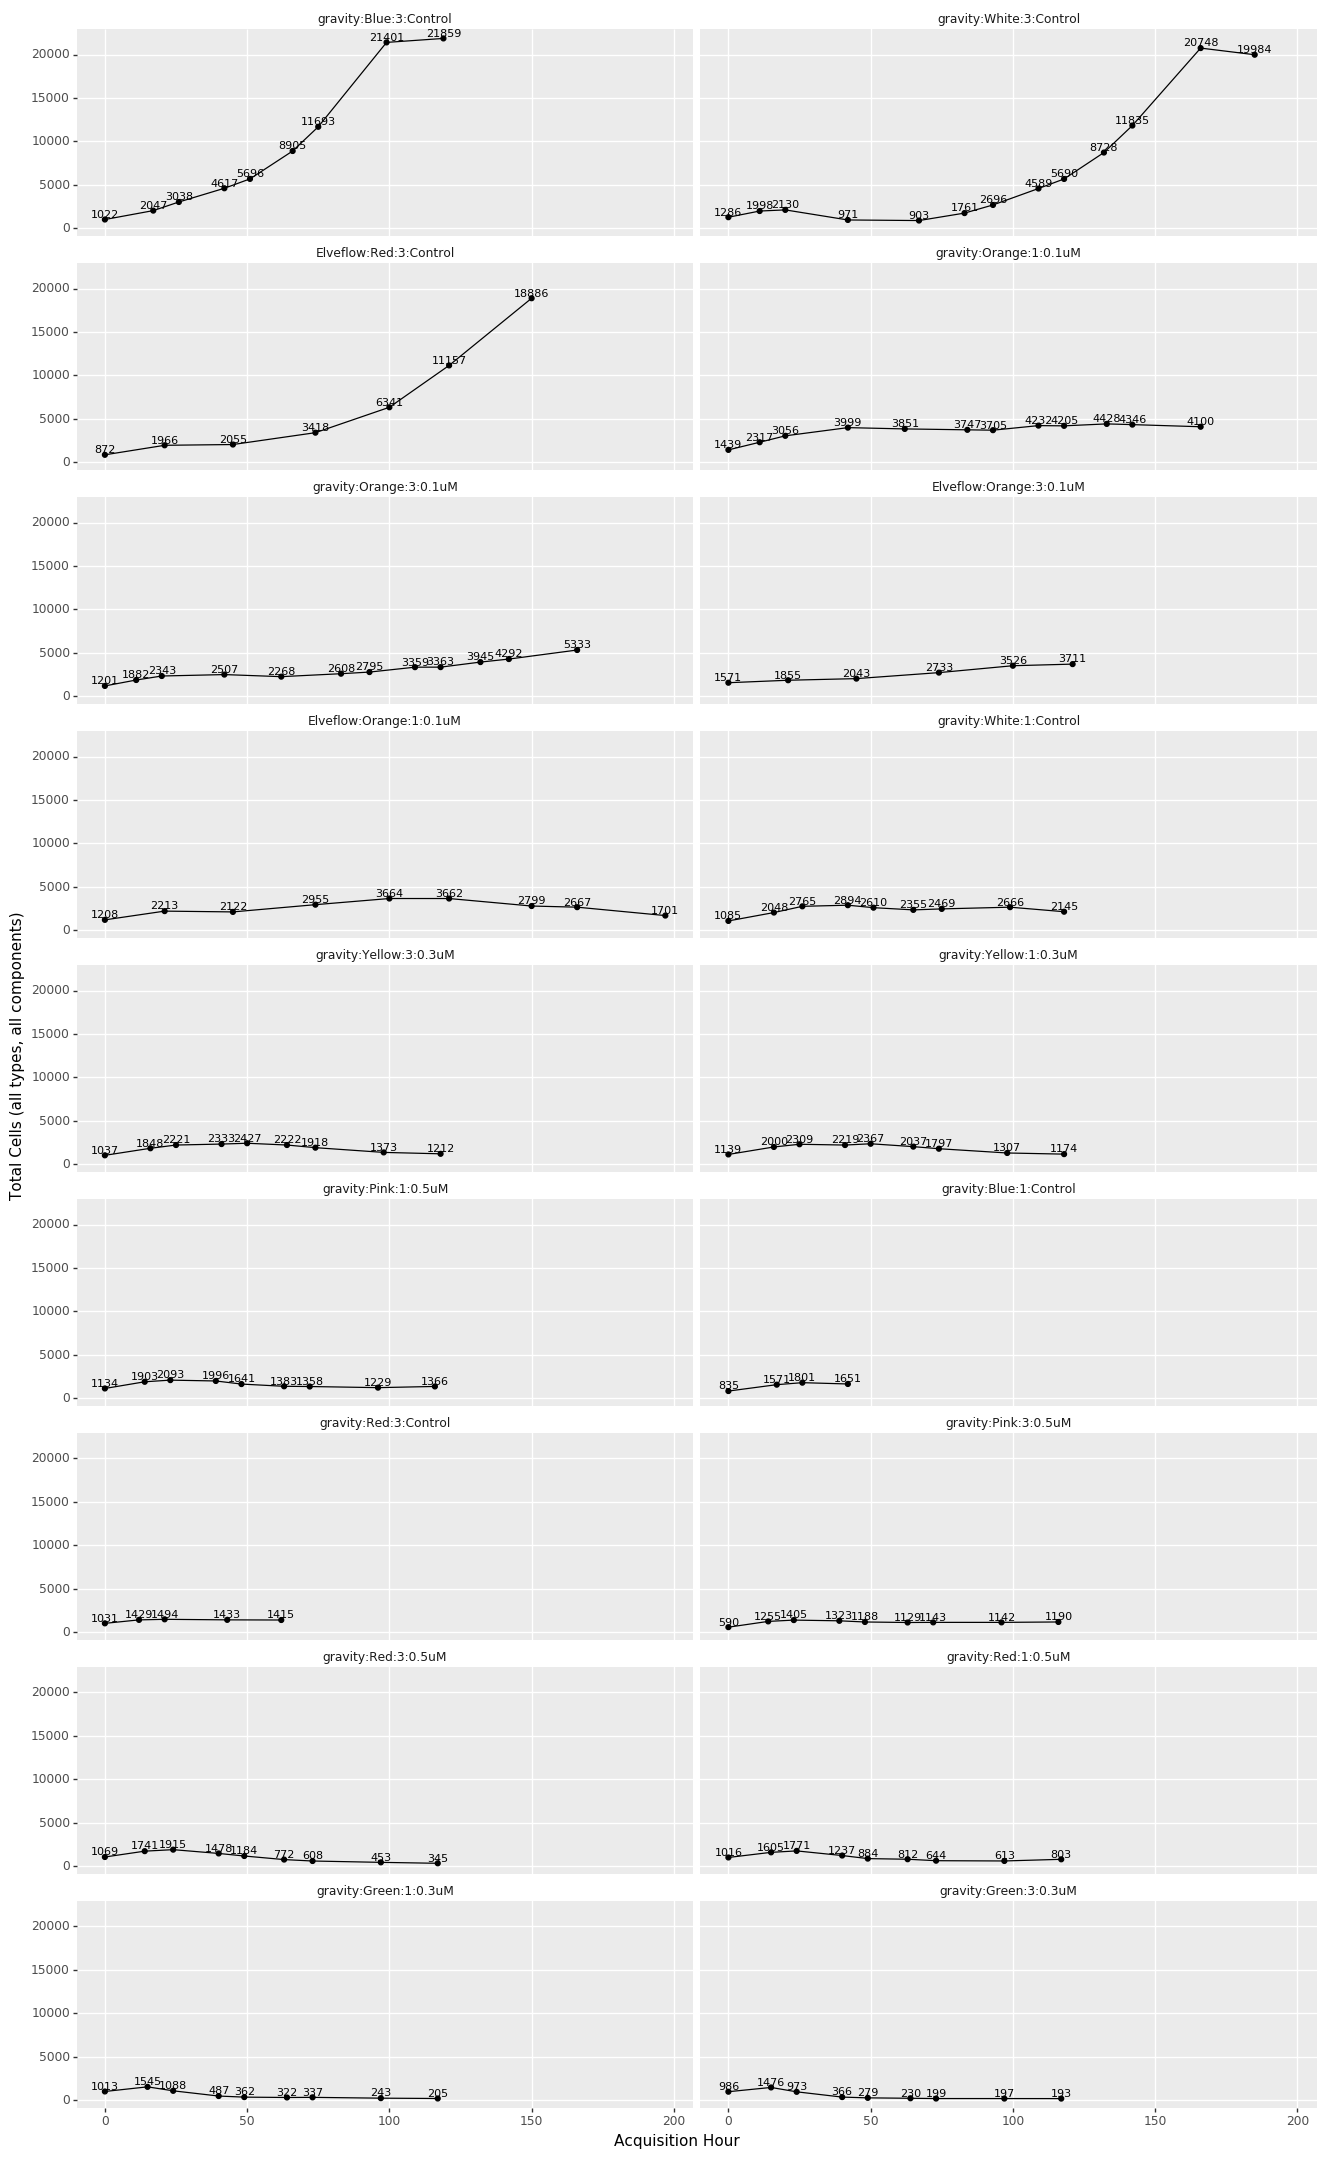

<ggplot: (8784805287102)>

In [16]:
count_field = 'cell_count'
df_ct = (
    df
    .groupby(['array', 'elapsed_hours_group'])[count_field].sum()
    .astype(int).rename('total_cell_count').reset_index()
)
arrct = df_ct['array'].nunique()
(
    pn.ggplot(
        df_ct
        .assign(array=pd.Categorical(
            df_ct['array'], ordered=True,
            categories=df_ct.groupby('array')['total_cell_count'].mean().sort_values(ascending=False).index
        )),
        pn.aes(x='elapsed_hours_group', y='total_cell_count', label='total_cell_count')
    ) + 
    pn.geom_line() + 
    pn.geom_point() + 
    pn.geom_text(size=8, va='bottom') + 
    pn.facet_wrap('~array', ncol=2) + 
    pn.xlab('Acquisition Hour') + 
    pn.ylab('Total Cells (all types, all components)') +
    pn.theme(
        figure_size=(16, 3 * int(np.ceil(arrct / 2))),
        panel_grid_minor=pn.element_blank(),
        strip_background=pn.element_rect(fill="white")
    )
)